# "Classifiez automatiquement des biens de consommation"
_NLP Cleaning Notebook_

## 0 Preliminaries

### 0.0 Importing Packages and Modules

Mounting my Drive (Colab)

In [1]:
from google.colab import files, output, drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


Installations and importations required in the virtual environment.

In [2]:
import os
# to set the current working directory
if os.getcwd()!='/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS':
    os.chdir('/gdrive/My Drive/--DATA SCIENCE/PROJET6/NOTEBOOKS')

Installations (creating the requirements file)

In [3]:
!pip install gtts
!pip install wikipedia2vec==0.2.2
!pip install opencv-contrib-python==3.4.2.17
!pip install opencv-python==3.4.2.17
!pip install category-encoders

  Created wheel for gtts-token: filename=gTTS_token-1.1.3-cp36-none-any.whl size=4096 sha256=da4c6079988c3b6d790702ab651b433d985e854d963b2a7f1560ec27f5417883
  Stored in directory: /root/.cache/pip/wheels/dd/11/61/33f7e51bf545e910552b2255eead2a7cd8ef54064b46dceb34
Successfully built gtts-token
     |████████████████████████████████| 1.1MB 3.4MB/s 
     |████████████████████████████████| 276kB 13.1MB/s 
     |████████████████████████████████| 143kB 18.0MB/s 
  Created wheel for wikipedia2vec: filename=wikipedia2vec-0.2.2-cp36-cp36m-linux_x86_64.whl size=4423143 sha256=c4ae91e6ae451d3f7d30f48ff48bc2036ecd3f4a34a509162e98925e3534e422
  Stored in directory: /root/.cache/pip/wheels/bf/bc/96/1ac030513bf05d0d47d5dc6d194a73595dbcd7d1ff79145130
  Created wheel for marisa-trie: filename=marisa_trie-0.7.5-cp36-cp36m-linux_x86_64.whl size=861296 sha256=2d00a299caea156ad6efa2592ecc06c017892d122e36179e9c7b402524a7bad5
  Stored in directory: /root/.cache/pip/wheels/45/24/79/022624fc914f0e559fe8a1141a

Importation of modules and packages. 

In [4]:
import io
import string
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import nltk
nltk.download('punkt')
nltk.download('stopwords')
plt.rcParams['figure.facecolor']='w'

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


Setting pandas display options.

In [5]:
dictPdSettings = {'display.max_rows': 500, 'display.width': 100,
                  'display.max_colwidth': 100,
                  'display.float_format': lambda x: '%.2f' % x}
for k,v in dictPdSettings.items():
  pd.set_option(k,v)

### 0.1 Importing the datasets

In [6]:
df = pd.read_csv("../DATA/flipkart_com-ecommerce_sample_1050.csv",
                 sep=',', 
                 index_col = 'uniq_id',
                 encoding ='utf-8')

### 0.2 Categories

In [7]:
# Converting the strings in 'product_category_tree' column in 6 categ columns

ser_depth = df['product_category_tree'].apply(lambda x: x.count('>>'))
max_depth = ser_depth.max() # maximum tree depth of categories

def str_cleaning(ind, my_str, name_level_cols):
    my_str = my_str.replace("[\"", "").replace("\"]", "")
    tab_str = my_str.split(">>")
    size_tab_str = len(tab_str)
    tup_str = tuple([tab_str[i].strip() if i<size_tab_str else "" \
                     for i in np.arange(max_depth) ])
    return tup_str

name_level_cols = ['cat_level_'+str(i) for i in np.arange(max_depth)]
ser_tuple = df['product_category_tree']\
    .apply(lambda s: str_cleaning(s.index, s, name_level_cols))
df_cat_level = pd.DataFrame([[a,'/'.join([a,b]),'/'.join([a,b,c]),
                              '/'.join([a,b,c,d]),'/'.join([a,b,c,d,e]),
                              '/'.join([a,b,c,d,e,f])] \
                             for a,b,c,d,e,f in ser_tuple.values],
                            columns=name_level_cols, index=df.index)

In [8]:
# Renaming the categories

df_cat_level['category'] = \
    df_cat_level['cat_level_0'].replace({'Home Furnishing': 'Furnishing',
                                        'Baby Care': 'Baby', 
                                        'Watches': 'Watches',
                                        'Home Decor & Festive Needs': 'Decor',
                                        'Kitchen & Dining': 'Kitchen',
                                        'Beauty and Personal Care': 'Beauty',
                                        'Computers': 'Computers'})

### 1.2 Products descriptions

In [9]:
# Extracting only useful data

df_desc_cat = pd.concat([df_cat_level['category'],
                         df[["product_name", "description"]]], axis=1)

### FUNCTIONS (can be put in a P6_functions.py file, and imported)

In [10]:
## to use if you want to import a P6_functions.py file, where you can put
## the content of the FUNCTIONS paragraph of this notebook

# from P6_functions import *

#### tokenize_clean

In [11]:
''' from a sentence, containing words (document):
- tokenizes the words if only composed of alphanumerical data,
- removes stopwords if list is given (stopwords)
- stems the words if stemmer given
NB: This pre-processing function can be used to prepare data for Word2Vec
'''
from nltk.stem.snowball import EnglishStemmer
import spacy

def tokenize_clean(document, stopwords=None, lemmatizer=None, stemmer=None):
    # 1 - tokenizing the words in each description
    tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
    li_words = tokenizer.tokenize(document)
    if stopwords is None: stopwords=[]
    # 2 - lemmatizing or stemming
    if lemmatizer is not None:
        lem_doc = lemmatizer(' '.join(li_words))
        li_words = [token.lemma_ for token in lem_doc]
    elif stemmer is not None:
        li_words = [stemmer.stem(s) for s in li_words]
    # 3 - removing stopwords
    li_words = [s for s in li_words if s not in stopwords]
    # 4 - lower case
    li_words = [s.lower() for s in li_words]
    return li_words

#### compute_doc_terms_df

In [12]:
''' Takes a pd.Series containing the texts of each description
applies a preprocessing function if given (stopwords, stemming...)
then turn the descriptions in vectors (bow of tf-idf, depending on the avlue of
 tfidf_on)
 returns document term matrix as a dataframe and the list of new excluded words.
'''

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

def compute_doc_terms_df(ser_desc, 
                         preproc_func=None,
                         preproc_func_params=None,
                         vec_params = {'min_df': 1},
                         tfidf_on=False,
                         print_opt=False):

    # ---- Apply a stemming of lemmatization prior to vectorization
    if preproc_func is not None:
        ser_desc = ser_desc.apply(lambda x: preproc_func(x,
                                                         **preproc_func_params))
        ser_desc = ser_desc.apply(lambda x: ' '.join(x))
    else:
        ser_desc = ser_desc
    
    # ---- Vectorization of each of the texts (row)
    if tfidf_on:
        # TF-IDF matrix
        vec = TfidfVectorizer(**vec_params)
    else:
        # BOW matrix (count)
        vec = CountVectorizer(**vec_params)

    doc_term = vec.fit_transform(ser_desc)
    if print_opt:
        print( "Created %d X %d doc_term matrix" % (doc_term.shape[0],
                                                    doc_term.shape[1]))

    # ---- Vocabulary of the document_term matrix
    doc_term_voc = vec.get_feature_names()
    if print_opt:
        print("Vocabulary has %d distinct terms" % len(doc_term_voc))

    # ---- Get the list of the new stop-words
    new_sw = vec.stop_words_
    if print_opt:
        print("Old stop-words list has %d entries" % len(sw) )
        print("New stop-words list has %d entries" % len(new_sw))

    doc_term_df = pd.DataFrame(doc_term.todense(),
                index=ser_desc.index, # each item
                columns=doc_term_voc) # each word

    # document term matrix as a dataframe and the list of new excluded words
    return doc_term_df, new_sw


#### CustNLPTransformer

In [13]:

''' Builds a customizable NLP column_transformer which parameters
can be optimized in a GridSearchClust
'''
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
import pandas as pd


class CustNLPTransformer(BaseEstimator):

    def __init__(self, stopwords=None, stemmer=None, lemmatizer=None,
                 min_df=0, max_df=10000, max_features=10000, tfidf_on=False,
                 ngram_range=(1,1), binary=False):
        self.stopwords = stopwords
        self.lemmatizer = lemmatizer
        self.stemmer = stemmer
        self.min_df = min_df
        self.max_df = max_df
        self.max_features = max_features
        self.tfidf_on = tfidf_on
        self.ngram_range = ngram_range
        self.binary = binary
        self.preproc_func_params={'stopwords': self.stopwords,
                                  'lemmatizer': self.lemmatizer,
                                  'stemmer': self.stemmer}
        self.vec_params = {'min_df': self.min_df,
                           'max_df': self.max_df,
                           'max_features': self.max_features,
                           'ngram_range': self.ngram_range,
                           'binary': self.binary}

    def __tokenize_clean(self, document, stopwords, lemmatizer, stemmer):
        # 1 - tokenizing the words in each description
        tokenizer = nltk.RegexpTokenizer(r'[a-z]+')
        li_words = tokenizer.tokenize(document)
        if stopwords is None: stopwords=[]
        # 2 - lemmatizing or stemming
        if lemmatizer is not None:
            lem_doc = lemmatizer(' '.join(li_words))
            li_words = [token.lemma_ for token in lem_doc]
        elif stemmer is not None:
            li_words = [stemmer.stem(s) for s in li_words]
        # 3 - removing stopwords
        li_words = [s for s in li_words if s not in stopwords]
        # 4 - lower case
        li_words = [s.lower() for s in li_words]
        return li_words

    # "private" method to be used to apply transformation and get a df
    def __compute_doc_terms_df(self, ser_desc, preproc_func,
                             preproc_func_params, vec_params, tfidf_on):
        # ---- Apply a stemming or lemmatization prior to vectorization
        if preproc_func is not None:
            ser_desc = ser_desc.apply(lambda x: \
                                      preproc_func(x, **preproc_func_params))
            ser_desc = ser_desc.apply(lambda x: ' '.join(x))
        else:
            ser_desc = ser_desc
        # ---- Vectorization of each of the texts (row)
        if tfidf_on:
            # TF-IDF matrix
            vec = TfidfVectorizer(**vec_params)
        else:
            # BOW matrix (count)
            vec = CountVectorizer(**vec_params)
        doc_term = vec.fit_transform(ser_desc)
        # ---- Vocabulary of the document_term matrix
        doc_term_voc = vec.get_feature_names()
        # ---- Get the list of the new stop-words
        new_sw = vec.stop_words_
        doc_term_df = pd.DataFrame(doc_term.todense(),
                                   index=ser_desc.index, # each item
                                   columns=doc_term_voc) # each word
        # document term matrix as a dataframe and the list of new excluded words
        return doc_term_df

    def fit(self, X, y=None):
        # nothing to fit
        return self

    def transform(self, X, y=None):  # to get a dataframe
        df_trans = \
            self.__compute_doc_terms_df(
                ser_desc=X,
                preproc_func=self.__tokenize_clean,
                preproc_func_params=self.preproc_func_params,
                vec_params=self.vec_params,
                tfidf_on=self.tfidf_on
                                   )
        return df_trans

    def fit_transform(self, X, y=None):
        return self.transform(X, y)

#### GridSearchClust

In [14]:
'''
Class to optimize clustering score.
Instantiate with a clusterer (estimator), a grid parameter (param_grid)
and a scoring function or a dict of scores (scoring) to be translated
in actual scores (see the compute_score)
'''

import numpy as np
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.model_selection import ParameterGrid
from collections import defaultdict
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score

class GridSearchClust(BaseEstimator, TransformerMixin):

    def __init__(self, estimator, param_grid_estim, param_grid_preproc=None,
                 scoring=None, scoring_true_lab=None, refit='silh',
                 greater_is_better=True):

        # Get the parameters
        self.estimator = estimator
        self.param_grid_estim = param_grid_estim
        self.param_grid_preproc = param_grid_preproc
        self.scoring = scoring
        self.scoring_true_lab = scoring_true_lab
        self.refit = refit
        self.greater_is_better = greater_is_better

    def __compute_score(self, X, clust_lab, n_score):

        dict_scores = {
            # Scores related to the clusters labels found by our estimator
               'silh': silhouette_score(X, clust_lab),
               'cal-har': calinski_harabasz_score(X, clust_lab),
               'dav_bould': davies_bouldin_score(X, clust_lab),
            # Scores comparing true labels and clusters found by our estimator
               'ami': adjusted_mutual_info_score(self.scoring_true_lab, clust_lab),
               'ari': adjusted_rand_score(self.scoring_true_lab, clust_lab),
               'homog': homogeneity_score(self.scoring_true_lab, clust_lab),
               'complet': completeness_score(self.scoring_true_lab, clust_lab)
               }
        return dict_scores[n_score]


    def fit(self, X, verbose=False):

        # Initialize the dict of results
        self.results_ = {"scores": {},
                         "params": [],
                         "estimators": [],
                        #  "fit_times": [],
                         "refit_score": []}

        # Iterate upon all combinations of parameters
        estim_score = defaultdict(list)
        for param in ParameterGrid(self.param_grid_estim):

            # Change the parameters of the estimator
            self.estimator = self.estimator.set_params(**param)

            # Fit the model
            self.estimator.fit(X)

            # If the estimator is a pipe, compute the first steps separately
            if hasattr(self.estimator, 'steps'): # if estimator is a pipeline
                pipe_wo_last_estim = Pipeline(self.estimator.steps[0:-1])
                X_trans = pipe_wo_last_estim.fit_transform(X)

            # Compute the labels
            labels = self.estimator.predict(X)

            # # Measure training time while fitting the model on the data
            # time_train = %timeit -n1 -r1 -o -q self.estimator.fit(X)
            # time_train = time_train.average

            # Compute the refit score
            try:
                if hasattr(self.estimator, 'steps'): # if estimator is a pipeline
                    refit_score = self.__compute_score(X_trans, labels, self.refit)
                else:
                    refit_score = self.__compute_score(X, labels, self.refit)
            except:
                print('ERREUR calcul refit_score: is scoring_true_lab correctly set ?')
                refit_score = np.nan
            
            # Other scores (scoring)
            if not self.scoring:  # if scoring parameter is/are not defined
                estim_score['score'] = {'default_score': self.estimator.score(X_trans, labels)} # default score
            else:  # If scoring parameter is/are defined
                if type(self.scoring) != list:
                    self.scoring = [self.scoring]
                else:
                    # looping over each score in the scoring list
                    for n_sco in self.scoring:
                        try:
                            if hasattr(self.estimator, 'steps'): # if estimator is a pipeline
                                estim_score[n_sco] = estim_score[n_sco] + \
                                    [self.__compute_score(X_trans, labels, n_sco)]
                            else:
                                estim_score[n_sco] = estim_score[n_sco] + \
                                    [self.__compute_score(X, labels, n_sco)]
                        except:
                            estim_score[n_sco] = estim_score[n_sco] + [np.nan]
                            print("ERROR: scores computation doesn't work")
            if verbose: print(estim_score)

            # saving results, parameters and models in a dict
            self.results_["refit_score"].append(refit_score)  # refit score
            self.results_["params"].append(param)  # parameters
            self.results_["estimators"].append(self.estimator)  # trained models
            # self.results_["fit_times"].append(time_train)  # training time

        self.results_["scores"] = dict(estim_score)  # dict of lists of scores
        self.results_["refit_score"] = np.array(self.results_["refit_score"])
  
        # Selecting best model based on the refit_score
        # -----------------------------------
        # initialisation
        best_estim_index, best_score = None, None  
        # iterating over scores
        for index, score in enumerate(self.results_["refit_score"]):

            # initialisation
            if not best_score:
                best_score = score
                best_estim_index = index

            # if score is better than current best_score
            cond = score > best_score if self.greater_is_better\
                                                 else score < best_score
            if cond:
                    # update the current best_score and current best_estim_index
                    best_score = score
                    best_estim_index = index
        
        # Update attributes of the instance
        self.best_score_ = self.results_["refit_score"][best_estim_index]
        self.best_params_ = self.results_["params"][best_estim_index]
        self.best_estimator_ = self.results_["estimators"][best_estim_index]
        self.best_index_ = best_estim_index
        # self.refit_time_ = self.results_["fit_times"][best_estim_index]

        # refit the best model
        self.best_estimator_.fit(X)
        
        return self

    def predict(self, X):

        # use the .predict method of the estimator on the best model
        return self.best_estim.predict(X)

#### filters_gsclust_results

In [15]:
''' Takes a GridSearchClust object and the name of one parameter of the
estimator (or of the pipeline) and isolate the influence of this parameter
on all the scores available in the scv (scoring)
-> returns a dictionary of the best other fixed parameters
and a dataframe of the scores depending on the chosen parameter and a 
filtered results_ dataframe that can be used
in the 'plot_scv_multi_scores' function '''

def filters_gsclust_results(gsc, param, return_df_res=False):

    gsc_res = gsc.results_
    # Generate a dataframe of all the models tested, their scores and parameters
    df_gsc = pd.DataFrame()
    for k, v in gsc_res.items():
        if type(v) == dict: # dict de listes : scores
            df_ = pd.DataFrame(v)
        elif type(v) == list:
            if type(v[0]) == dict: # liste de dicts : params
                df_ = pd.DataFrame(v)
                li_params = df_.columns
            else: # liste d'objets (estimators) ou de nombres (refit_score)
                df_ = pd.DataFrame(v, columns=[k])
        else:
            col_names = [str(k)]
            df_ = pd.DataFrame(v, columns=[k])
        df_gsc = pd.concat([df_gsc, df_], axis=1)
    df_gsc_transl = object_none_translater(df_gsc)

    # selects in the data frame the best params
    best_params = gsc.best_params_.copy() # dict of the best params
    # translation of all the non numeric values into strings (including None)
    best_params_transl = object_none_translater(best_params) 
    del best_params_transl[param] # remove the parameter that we want to plot

    # filters in the result dataframe only optimized results except for 'param'
    mask = np.full((df_gsc_transl.shape[0],), True)
    for k,v in best_params_transl.items():
        mask = mask & (df_gsc_transl[k]==v)
    df_gsc_filt = df_gsc.loc[mask]
    li_scores = gsc.get_params()['scoring']          
    df_sel_scores = df_gsc_filt[li_scores+[param]].set_index(param)
    df_res = df_gsc_transl
    if return_df_res:
        return best_params, df_sel_scores, df_gsc_filt, df_res
    else:
        return best_params, df_sel_scores, df_gsc_filt

#### plot_gsc_multiscore

In [16]:
''' Plots a selection of scores (scores) or all the scores (scores=None)
obtained during the GridSearchClust as a collection of line graphs.
The other parameters (not plotted) are the parameters of the best estimator
(found by gridsearch). They're the same for all the line plot (contrary to
the 'plot_2Dgsclust_param_opt where other params may differ for each cell).
'''

def plot_gsc_multi_scores(gsc, param, title = None, x_log=False,
                          loc='best', figsize = (12, 4), scores=None):

    best_params, df_sel_scores, _ = filters_gsclust_results(gsc,param)
    results = df_sel_scores
    
    scoring = gsc.scoring if scores is None else scores

    fig, axs = plt.subplots(1,len(scoring))
    fig.set_size_inches(figsize)

    li_colors = ['b', 'r', 'g', 'purple', 'orange', 'brown', 'grey']
    if len(axs)==1 : axs = [axs]

    # Get the regular np array from the MaskedArray
        
    X_axis = np.array(results.index, dtype='float')

    for scorer, color, ax in zip(sorted(scoring), li_colors[:len(scoring)], axs):
        score = df_sel_scores[scorer].values
        
        df_ = pd.DataFrame({'param': X_axis,
                            'score': score,
                            # 'std': None,
                            }).sort_values(by='param')
        # ax.fill_between(df_['param'],
        #                 df_['score'] - df_['std'],
        #                 df_['score'] + df_['std'],
        #                 alpha=0.1, color=color)
        ax.plot(df_['param'], df_['score'], '-', marker='o', markersize=3,
            color=color, alpha=1)
        if x_log: ax.set_xscale('log')
        ax.set_title(scorer)

        y_min, y_max = ax.get_ylim()
        
        # Plot a dotted vertical line at the best score for that scorer marked by x
        best_score = results.loc[best_params[param], scorer]
        ax.plot([best_params[param], ] * 2, [y_min - abs(y_min)*0.1, best_score],
            linestyle='dotted', color=color, marker='x', markeredgewidth=3, ms=8)
        ax.set_ylim(y_min, y_max)
        ax.set_xlabel(param)
        ax.set_ylabel("Score")
        # ax.legend(loc=loc)

        # Annotate the best score for that scorer
        len_str = len("{:.2f}".format(best_score))
        if best_params[param] < np.mean(X_axis):
            x_pos = best_params[param]*(1+0.015*len_str)
        else:
            x_pos = best_params[param]*(1-0.015*len_str)
        y_pos = best_score*1+(y_max-y_min)*0.05
        ax.annotate("{:0.2f}".format(best_score), 
                    (x_pos, y_pos),
                    color = color)  
    if title is not None:
        fig.suptitle(title, fontsize=16, fontweight='bold')
        plt.tight_layout(rect=(0,0,1,0.92))
    else:
        plt.tight_layout()
    plt.show()

#### plot_2D_gsclust_param_opt

In [17]:
''' Takes a GridSearchClust object and plots a heatmap of a chosen score (score)
against 2 chosen parameters.
NB: the score displayed for each cell is the one for the best other parameters.
'''

def plot_2D_gsclust_param_opt(gsc, params=None, score=None,
                           title=None, shorten_label=7, ax=None):

    ax = plt.subplot(1,1,1) if ax is None else ax

    score = 'refit_score' if score is None else score

    params_gsc = params

    _, _, _, df_res = filters_gsclust_results(gsc, params_gsc[0],
                                              return_df_res=True)
    max_scores = df_res.groupby(params_gsc).agg(lambda x: max(x))[score]
    sns.heatmap(max_scores.unstack(), annot=True, fmt='.4g', ax=ax)

    if shorten_label != False:
        thr = int(shorten_label)
        lab_x = [item.get_text() for item in ax.get_xticklabels()]
        short_lab_x = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_x]
        ax.axes.set_xticklabels(short_lab_x)
        lab_y = [item.get_text() for item in ax.get_yticklabels()]
        short_lab_y = [s[:thr]+'...'+s[-thr:] if len(s)>thr else s for s in lab_y]
        ax.axes.set_yticklabels(short_lab_y)

    title = score if title is None else title
    ax.set_title(title)

#### TopicsModeler

In [18]:
''' Builds a topics modeler which parameters (model, number of topics)
can be optimized in a GridSearchClust.
.transform: returns the DOCUMENTS/TOPICS matrix
.predict: returns the list of the most probable topic for each document
NB: takes a dataframe as X.
'''
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import *
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD
import numpy as np
import pandas as pd

class TopicsModeler(BaseEstimator):


    def __init__(self, n_model='nmf', n_components=7, random_state=None):#, model_params):

        self.n_model = n_model
        self.n_components = n_components
        self.random_state = random_state
        # self.model_params = model_param

        # Model name -> object
        self.dict_models = {'lsa': TruncatedSVD(),
                            'nmf': NMF(init="nndsvd"),
                            'lda': LDA()}

        # Instantiate the model
        try:
            self.model = self.dict_models[self.n_model]#.set_params(*self.model_params)
        except:
            print("ERROR: unknown topics modeliser. \n\
Please, choose between 'nmf', 'lda' and 'lsa'")

    def fit(self, X, y=None):

        # Re-Instantiate the model
        try:
            self.model = self.dict_models[self.n_model]#.set_params(*self.model_params)
        except:
            print("ERROR: unknown topics modeliser. \n\
Please, choose between 'nmf', 'lda' and 'lsa'")

        # Set the parameters
        self.model.set_params(n_components = self.n_components,
                              random_state = self.random_state)

        # Fit the model
        self.model.fit(X)

        return self

    def __compute_DOC_TOP_matrix(self, X, y=None): # DOCUMENTS/TOPICS Matrix
    # actualization of n_components
        self.n_components = self.model.transform(X.values).shape[1]
        self.W = pd.DataFrame(self.model.transform(X.values),
                              index=X.index, # documents
                              columns=['topic_'+str(i)\
                                       for i in range(1,self.n_components+1)]) # topics

    def __compute_TOP_WORDS_matrix(self, X, y=None): # TOPICS/WORDS Matrix

        self.H = pd.DataFrame(self.model.components_, 
                              index=['topic_'+str(i)\
                                     for i in range(1,self.n_components+1)], # topics
                              columns=X.columns) # words

    def transform(self, X, y=None):  # to get the df of the DOC/TOPICS matrix

        self.__compute_DOC_TOP_matrix(X)
        self.__compute_TOP_WORDS_matrix(X)

        # Converting topics scores to best cluster label (higher val column)
        ser_res = self.W.idxmax(1)

        return self.W

    def predict(self, X, y=None):  # to get a ser of the best label

        self.__compute_DOC_TOP_matrix(X)
        self.__compute_TOP_WORDS_matrix(X)

        # Converting topics scores to best cluster label (higher val column)
        ser_res = self.W.idxmax(1)

        return ser_res

    def fit_transform(self, X, y=None):
        self.fit(X, y)
        return self.transform(X, y)

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self.predict(X, y)

#### --- others ---

In [19]:
from sklearn.cluster import KMeans

def clustering_doc_matrix(doc_matrix_df, name, n_clusters=7):
    # Creating the Kmeans model
    km = KMeans(n_clusters = n_clusters)
    # Fitting the Kmeans model
    km.fit(doc_matrix_df)
    ser = pd.Series(km.labels_,
                    index = doc_matrix_df.index,
                    name = name)
    return ser

In [20]:
from sklearn.decomposition import NMF
from sklearn.decomposition import LatentDirichletAllocation as LDA
from sklearn.decomposition import TruncatedSVD

def topicsmodeler_doc_matrix(doc_matrix_df, n_model, name, n_components=7):

    dict_models = {'lsa': TruncatedSVD(),
                   'nmf': NMF(init="nndsvd"),
                   'lda': LDA()}
    model = dict_models[n_model]

    # Instantiation the topic modeler
    model.set_params(n_components = n_components)

    # Fitting the the topic modeler
    model.fit(doc_matrix_df)

    # DOCUMENTS/TOPICS Matrix
    W = pd.DataFrame(model.fit_transform(doc_matrix_df.values),
                     index=doc_matrix_df.index, # documents
                     columns=['topic_'+str(i)\
                              for i in range(1,n_components+1)]) # topics

    # TOPICS/WORDS Matrix
    H = pd.DataFrame(model.components_,
                     index=['topic_'+str(i)\
                            for i in range(1,n_components+1)], # topics
                     columns=doc_matrix_df.columns) # words

    # Converting topics scores to best cluster label (higher val column)
    ser_res = pd.Series(W.idxmax(1),
                        index = W.index,
                        name = name)

    return ser_res

In [21]:
''' Transformer that translates all the non numeric values into strings
(including None) in a dict or a dataframe (column wise)
'''
import numbers
# si contient des None, alors convertir tous les objects en string

def object_none_translater(dict_or_df):
    if type(dict_or_df) == dict:
        # Change any non numeric value to string
        dict_or_df_transl = {k: v if isinstance(v, numbers.Number) else str(v)\
                             for k,v in dict_or_df.items()}
    elif type(dict_or_df) == pd.core.frame.DataFrame:
        # Change None to str (so the type of any None-containing col becomes 'object')
        dict_or_df_transl = dict_or_df.fillna('None')
        # Convert the content of all object columns to strings
        cols = dict_or_df_transl.select_dtypes('object').columns
        dict_or_df_transl[cols] = dict_or_df_transl[cols].applymap(lambda x: str(x))
    else:
        print("ERROR: you passed an object to 'object_none_translater'\
 that is neither a dict nor a pd.DataFrame")
    return dict_or_df_transl


In [22]:
'''Takes a dataframe of clusters number (prediction) for a set of observation, 
and computes the ARI score between pairs of columns.
Two modes are available:
- first_vs_others=False: to check the initialisation stability.
The columns are obtains for n_columns iterations of the same model
with different initialisation
- first_vs_others=True: to compare the predictions obtained with the whole
dataset (first column) and predictions obtained with a sample
(the other columns)
Return a pd.Series of the ARI scores (values) for each pair of columns (index).
'''

from sklearn.metrics import adjusted_rand_score

def ARI_column_pairs(df_mult_ser_clust, first_vs_others=False, print_opt=True):

    n_columns = len(df_mult_ser_clust.columns)
    n_clust = df_mult_ser_clust.stack().nunique()
    
    # Computes ARI scores for each pair of models
    ARI_scores = []
    if first_vs_others: # first columns versus the others
        pairs_list = [[df_mult_ser_clust.columns[0],
                       df_mult_ser_clust.columns[i]] \
                      for i in range(1, n_columns)]
        if print_opt: print("--- ARI between first and the {} others ---"\
                            .format(n_columns-1))
        name = f'ARI_{str(n_clust)}_clust_first_vs_others'
    else: # all pairs
        pairs_list = combinlist(df_mult_ser_clust.columns,2)
        if print_opt: print("--- ARI all {} unique pairs ---"\
                            .format(len(pairs_list)))
        name = f'ARI_{str(n_clust)}_clust_all_pairs'

    for i, j in pairs_list:
        ARI_scores.append(adjusted_rand_score(df_mult_ser_clust.loc[:,i],
                                              df_mult_ser_clust.loc[:,j]))

    # Compute the mean and standard deviation of ARI scores
    ARI_mean, ARI_std = np.mean(ARI_scores), np.std(ARI_scores)
    ARI_min, ARI_max = np.min(ARI_scores), np.max(ARI_scores)
    if print_opt: print("ARI: mean={:.3f}, std={:.3f}, min={:.3f}, max={:.3f} "\
            .format(ARI_mean, ARI_std, ARI_min, ARI_max))

    return pd.Series(ARI_scores, index=pd.Index(pairs_list),
                     name=name)


In [23]:

''' Builds a customizable column_transformer which parameters can be optimized in a GridSearchCV
CATEGORICAL : three differents startegies for 3 different types of
categorical variables:
- low cardinality: customizable strategy (strat_low_card)
- high cardinality: customizable strategy (strat_high_card)
- boolean or equivalent (2 categories): ordinal
QUANTITATIVE (remainder): 
- StandardScaler

-> EXAMPLE (to use apart from gscv):
cust_enc = CustTransformer(thresh_card=12,
                       strat_binary = 'ord',
                       strat_low_card = 'ohe',
                       strat_high_card = 'loo',
                       strat_quant = 'stand')
cust_enc.fit(X_tr, y1_tr)
cust_enc.transform(X_tr).shape, X_tr.shape

-> EXAMPLE (to fetch names of the modified dataframe):
small_df = df[['Outlier', 'Neighborhood', 'CertifiedPreviousYear',
               'NumberofFloors','ExtsurfVolRatio']]
# small_df.head(2)
cust_trans = CustTransformer()
cust_trans.fit(small_df)
df_enc = cust_trans.transform(small_df)
cust_trans.get_feature_names(small_df)

'''
from sklearn.base import BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
import category_encoders as ce
from sklearn.preprocessing import *
import numpy as np
import pandas as pd


class CustTransformer(BaseEstimator):

    def __init__(self, thresh_card=12,
                 strat_binary='ord', strat_low_card='ohe',
                 strat_high_card='bin', strat_quant='stand'):
        self.thresh_card = thresh_card
        self.strat_binary = strat_binary
        self.strat_low_card = strat_low_card
        self.strat_high_card = strat_high_card
        self.strat_quant = strat_quant
        self.dict_enc_strat = {'binary': strat_binary,
                               'low_card': strat_low_card,
                               'high_card': strat_high_card,
                               'numeric': strat_quant}

    def d_type_col(self, X):
        bin_cols = (X.nunique()[X.nunique() <= 2].index)
        X_C_cols = X.select_dtypes(include=['object', 'category'])
        C_l_card_cols = \
            X_C_cols.nunique()[X_C_cols.nunique() \
                .between(3, self.thresh_card)].index
        C_h_card_cols = \
            X_C_cols.nunique()[X_C_cols.nunique() > self.thresh_card].index
        Q_cols = [c for c in X.select_dtypes(include=[np.number]).columns \
                  if c not in bin_cols]
        d_t = {'binary': bin_cols,
               'low_card': C_l_card_cols,
               'high_card': C_h_card_cols,
               'numeric': Q_cols}
        d_t = {k: v for k, v in d_t.items() if len(v)}
        # print(d_t)
        return d_t

    def get_feature_names(self, X, y=None):
        if self.has_num and self.has_cat:
            self.ct_cat.fit(X, y)
            cols = self.ct_cat.get_feature_names() + self.num_cols
        elif self.has_num and not self.has_cat:
            cols = self.num_cols
        elif not self.has_num and self.has_cat:
            self.ct_cat.fit(X, y)
            cols = self.ct_cat.get_feature_names()
        else:
            cols = None
        return cols

    def fit(self, X, y=None):
        # Dictionary to translate strategies
        d_enc = {'ohe': ce.OneHotEncoder(),
                 'hash': ce.HashingEncoder(),
                 'ord': ce.OrdinalEncoder(),
                 'loo': ce.LeaveOneOutEncoder(),
                 'bin': ce.BinaryEncoder(),
                 'stand': StandardScaler(),
                 'minmax': MinMaxScaler(),
                 'maxabs': MaxAbsScaler(),
                 'robust': RobustScaler(quantile_range=(25, 75)),
                 'norm': Normalizer(),
                 'quant_uni': QuantileTransformer(output_distribution='uniform'),
                 'quant_norm': QuantileTransformer(output_distribution='normal'),
                 'boxcox': PowerTransformer(method='box-cox'),
                 'yeo': PowerTransformer(method='yeo-johnson'),
                 'log': FunctionTransformer(func=lambda x: np.log1p(x),
                                            inverse_func=lambda x: np.expm1(x)),
                 'none': FunctionTransformer(func=lambda x: x,
                                             inverse_func=lambda x: x),
                 }

        # # dictionnaire liste des transfo categorielles EXISTANTES
        d_t = self.d_type_col(X)
        # numerics
        self.has_num = ('numeric' in d_t.keys())
        # categoricals
        self.has_cat = len([s for s in d_t.keys() if s in ['binary', 'low_card', 'high_card']]) > 0
        if self.has_cat:
            list_trans = []  # dictionnaire des transfo categorielles EXISTANTES
            for k, v in d_t.items():
                if k != 'numeric':
                    list_trans.append((k, d_enc[self.dict_enc_strat[k]], v))

            self.cat_cols = []  # liste des colonnes catégorielles à transformer
            for k, v in self.d_type_col(X).items():
                if k != 'numeric': self.cat_cols += (list(v))

            self.ct_cat = ColumnTransformer(list_trans)
            self.cat_trans = Pipeline([("categ", self.ct_cat)])

        if self.has_num:
            self.num_trans = Pipeline([("numeric", d_enc[self.strat_quant])])
            self.num_cols = d_t['numeric']

        if self.has_num and self.has_cat:
            self.column_trans = \
                ColumnTransformer([('cat', self.cat_trans, self.cat_cols),
                                   ('num', self.num_trans, self.num_cols)])
        elif self.has_num and not self.has_cat:
            self.column_trans = \
                ColumnTransformer([('num', self.num_trans, self.num_cols)])
        elif not self.has_num and self.has_cat:
            self.column_trans = ColumnTransformer([('cat', self.cat_trans, self.cat_cols)])
        else:
            print("The dataframe is empty : no transformation can be done")

        return self.column_trans.fit(X, y)

    def transform(self, X, y=None):  # to get a dataframe
        return pd.DataFrame(self.column_trans.transform(X),
                            index=X.index,
                            columns=self.get_feature_names(X, y))

    def fit_transform(self, X, y=None):
        if y is None:
            self.fit(X)
            return pd.DataFrame(self.column_trans.transform(X),
                                index=X.index,
                                columns=self.get_feature_names(X, y))
        else:
            self.fit(X, y)
            return pd.DataFrame(self.column_trans.transform(X, y),
                                index=X.index,
                                columns=self.get_feature_names(X, y))



/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## 3 One parameter optimization loop (example on max_features on BOW)

In [24]:
df_res_clust = pd.DataFrame()
df_res_clust['categories'] = df_desc_cat['category']

Descriptions pre-processing

In [25]:
# Stopwords
english_sw = nltk.corpus.stopwords.words('english')
single_let_sw = list(string.ascii_lowercase)
sw = list(set(english_sw + single_let_sw))
len(sw)

197

In [26]:
# Stemmer or lemmatizer
from nltk.stem.snowball import EnglishStemmer
import spacy

stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

In [27]:
# Vectorization of the descriptions prior to applying NMF

doc_matrix_df, _ = \
    compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None,
                                                'lemmatizer': lemmatizer},
                         vec_params = {'min_df': 5, # min nb of descriptions that must contain the word
                                       'max_features':500}, # max nb of words to keep among the most used
                         tfidf_on=False)

#### KMeans Clustering

Loop optimisation of the max_feature parameter on ARI

In [28]:
# Getting the labels of clustering for each set of param (1 param)

max_features_list = [30, 70, 100, 150, 250, 500, 1000]

for max_feat in max_features_list:
    doc_matrix_df, _ = \
        compute_doc_terms_df(df_desc_cat['description'],
                         preproc_func= tokenize_clean,
                         preproc_func_params = {'stopwords': sw,
                                                'stemmer': None,
                                                'lemmatizer': lemmatizer},
                         vec_params = {'min_df': 5, # min nb of descriptions that must contain the word
                                       'max_features':max_feat}, # max nb of words to keep among the most used
                         tfidf_on=False)
    # Appending the best results of the Kmeans clustering
    df_res_clust = pd.concat([df_res_clust,
                              clustering_doc_matrix(doc_matrix_df,
                                                    name='KM_'+str(max_feat))],
                             axis=1)

In [29]:
df_res_clust.sample(5)

,categories,KM_30,KM_70,KM_100,KM_150,KM_250,KM_500,KM_1000
uniq_id,,,,,,,,
198dbe7be6f84f6448197148d7b5e5a5,Decor,3,4,2,1,0,0,3
20a06aad5f04727dd54bf13dd5923518,Decor,0,5,0,0,1,2,0
daf06eb2b9613900299539558e287701,Kitchen,0,3,5,2,4,5,2
04f9ff160a1561e3656350f4bd6b8c50,Furnishing,5,3,5,5,4,5,6
d61b368146f83075937e144dab93c6a1,Beauty,1,0,1,3,0,6,3


In [30]:
# Comparison of clusters labels with true categories

from sklearn.metrics import adjusted_rand_score

ser_ari_pairs_models = ARI_column_pairs(df_res_clust, first_vs_others=True,
                                        print_opt=True)

--- ARI between first and the 7 others ---
ARI: mean=0.118, std=0.043, min=0.046, max=0.155 


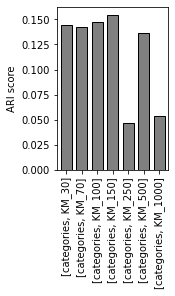

In [31]:
# Plotting the results

fig = plt.figure(figsize=(2,3))
ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ARI score')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

#### Topics Modeler Clustering

Loop optimisation of the max_feature parameter on ARI

In [32]:
# Getting the labels of clustering for each set of param (1 param)

max_features_list = [30, 70, 100, 150, 250, 500, 1000]

for max_feat in max_features_list:
    doc_matrix_df, _ = \
        compute_doc_terms_df(df_desc_cat['description'],
                             preproc_func= tokenize_clean,
                             preproc_func_params = {'stopwords': sw,
                                                    'stemmer': None,
                                                    'lemmatizer': lemmatizer},
                             vec_params = {'min_df': 5, # min nb of descriptions that must contain the word
                                           'max_features':max_feat}, # max nb of words to keep among the most used
                             tfidf_on=False)
    # Appending the best results of the Topics Modeler clustering
    df_res_clust = pd.concat([df_res_clust,
                              topicsmodeler_doc_matrix(doc_matrix_df,
                                                         n_model='nmf',
                                                         name='TM_'+str(max_feat),
                                                         n_components=7)],
                             axis=1)
                            #   clustering_doc_matrix(doc_matrix_df,
                            #                         str(max_feat))], axis=1)

In [33]:
df_res_clust.sample(5)

,categories,KM_30,KM_70,KM_100,KM_150,KM_250,KM_500,KM_1000,TM_30,TM_70,TM_100,TM_150,TM_250,TM_500,TM_1000
uniq_id,,,,,,,,,,,,,,,
2476ae5a5e045876aa08f5919cb3b91b,Furnishing,6,2,0,5,1,2,0,topic_3,topic_3,topic_3,topic_3,topic_3,topic_3,topic_3
c44a5dc5b5ebe5b3e0535b7c2b7921e4,Baby,2,5,6,6,1,2,0,topic_7,topic_4,topic_5,topic_5,topic_6,topic_6,topic_6
597a9549a3e397d52dca62ee47b1f60a,Furnishing,0,3,5,2,1,5,2,topic_1,topic_1,topic_1,topic_1,topic_1,topic_1,topic_1
291d5ff1e50dac3058cf10578f692085,Computers,1,0,1,3,0,6,3,topic_2,topic_2,topic_2,topic_2,topic_2,topic_2,topic_2
52877a6306aef18af67ab54c8233c931,Kitchen,2,5,0,0,1,2,0,topic_7,topic_3,topic_3,topic_3,topic_3,topic_3,topic_3


In [34]:
# Comparison of clusters labels with true categories

from sklearn.metrics import adjusted_rand_score

ser_ari_pairs_models = ARI_column_pairs(df_res_clust, first_vs_others=True,
                                        print_opt=True)

--- ARI between first and the 14 others ---
ARI: mean=0.123, std=0.046, min=0.046, max=0.174 


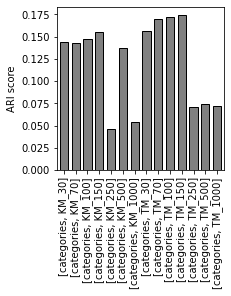

In [35]:
# Plotting the results

fig = plt.figure(figsize=(3,3))
ser_ari_pairs_models.plot.bar(width=0.7, color='grey', ec='k')
plt.ylabel('ARI score')
# plt.title('ARI score comparing the cluster\nlabel prediction of pairs of models')
# plt.gca().set(ylim=(0.85,1))
plt.show()

## 4 GridSearch optimization of the text preprocessing parameters

### 4.0 Simple GridSearch with clusterer parameters optimization (without pipeline)

#### KMeans

The clusterer is a KMeans.

In [36]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
completeness_score, homogeneity_score

# Definition of the hyperparameters grid
param_grid = {"n_clusters": [4,5,6,7,8],
              "random_state": range(10)} # to check easily for initialization stability

# Instanciation of the GridSearch object
gsc = GridSearchClust(estimator=KMeans(), # random_state=14
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True, # for the refit_score
                      )

# Computing the results of the grid search
gsc.fit(doc_matrix_df, verbose=False);

In [37]:
# Displays best parameters
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_
scores_df = pd.DataFrame(gsc_res['scores'],
                         index = pd.DataFrame(gsc_res['params'])\
                                 .loc[:,'n_clusters'])
scores_df

Best hyperparameters: {'n_clusters': 8, 'random_state': 4}
Best refit score: 0.15734474118209268


,silh,cal-har,dav_bould,ami,ari,homog,complet
n_clusters,,,,,,,
4,0.37,104.77,1.68,0.06,0.01,0.04,0.16
4,0.23,118.05,2.49,0.07,0.04,0.06,0.12
4,0.23,120.48,2.45,0.09,0.05,0.07,0.14
4,0.44,109.12,1.55,0.05,0.01,0.04,0.15
4,0.23,112.40,2.48,0.09,0.05,0.07,0.14
4,0.43,112.65,1.66,0.06,0.01,0.04,0.16
4,0.23,120.48,2.45,0.09,0.05,0.07,0.14
4,0.23,120.36,2.47,0.09,0.05,0.07,0.13
4,0.23,120.48,2.45,0.09,0.05,0.07,0.14


#### TopicsModeler

The clusterer is a custom topics modeler using either NMF, LSA or LDA to find most probable topic for each description.

In [38]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
completeness_score, homogeneity_score

# Definition of the hyperparameters grid
param_grid = {"n_components": [4,5,6,7,8],
              "n_model": ['lda', 'nmf', 'lsa']}

# Instanciation of the GridSearch object
gsc = GridSearchClust(estimator=TopicsModeler(random_state=14),
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ari',
                      greater_is_better=True, # for the refit_score
                      )

# Computing the results of the grid search
gsc.fit(doc_matrix_df, verbose=False);

In [39]:
# Displays best parameters
print("Best hyperparameters:", gsc.best_params_)
print("Best refit score:", gsc.best_score_)
gsc_res = gsc.results_
scores_df = pd.DataFrame(gsc_res['scores'],
                         index = pd.DataFrame(gsc_res['params']).loc[:,'n_model'])
scores_df

Best hyperparameters: {'n_components': 7, 'n_model': 'lda'}
Best refit score: 0.21076823996883529


,silh,cal-har,dav_bould,ami,ari,homog,complet
n_model,,,,,,,
lda,0.04,72.17,2.78,0.24,0.13,0.20,0.32
nmf,0.21,91.00,2.73,0.13,0.06,0.10,0.18
lsa,0.18,77.93,2.57,0.10,0.05,0.08,0.15
lda,0.04,62.37,3.16,0.31,0.19,0.27,0.37
nmf,0.22,78.01,2.64,0.13,0.06,0.11,0.18
lsa,0.19,67.36,2.32,0.11,0.05,0.09,0.16
lda,0.05,51.50,3.48,0.33,0.21,0.31,0.38
nmf,0.21,67.72,2.89,0.19,0.07,0.17,0.25
lsa,0.21,61.89,2.32,0.17,0.07,0.15,0.23


### 4.1 GridSearch optimization of all the hyperparameters of a pipeline

#### preprocessing and PCA parameters with KMeans clustering

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 3 steps:
- Custom NLP transformer (BOW or TFIDF matrix)
- Dimensionality reduction (PCA)
- KMeans clustering (7 categories)

In [40]:
import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score
from sklearn.decomposition import PCA
from nltk.stem.snowball import EnglishStemmer
import spacy

# Define the stemmer or the lemmatizer
stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])

# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('stand', CustTransformer(strat_quant='stand')), # Standardizer
                 ('pca', PCA()), # PCA feature reduction
                 ('clusterer', KMeans(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {'custtrans__stopwords': [sw], # [sw, None],
              'custtrans__stemmer': [None],#[stemmer, None],
              'custtrans__lemmatizer': [lemmatizer], #, None],
              'custtrans__min_df': (np.linspace(0,30,2)).astype('int'),
              'custtrans__max_df': [1500],
              'custtrans__max_features': [5000],
              'custtrans__ngram_range': [(1,1), (1,2)], #, (2,2), (2,3), (3,3), (1,2,3)],
              'custtrans__binary': [True], #, False],
              'custtrans__tfidf_on': [True], #, False],
              'pca__n_components': [6,10,20],# [15,20,25,30,35,40],
              'clusterer__n_clusters': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ami',
                      greater_is_better=True) # for the refit_score

In [41]:
##### Perform the grid search on the whole descriptions
gsc_desc = copy.deepcopy(gsc)
gsc_desc.fit(df_desc_cat['description'], verbose=False);

##### Perform the grid search on the product names
gsc_pname = copy.deepcopy(gsc)
gsc_pname.fit(df_desc_cat['product_name'], verbose=False);

Code to pickle the results of a grisdearch in a .pkl file

In [42]:
# ### Pickling the results
# import dill as pickle
# with open('gsc_prep_pca_km_WD.pkl', 'wb') as file:
#     pickle.dump(gsc_desc, file)
# with open('gsc_prep_pca_km_PN.pkl', 'wb') as file:
#     pickle.dump(gsc_pname, file)

Code to load pickled results

In [43]:
# ### Loading the results
# import dill as pickle
# with open('gsc_prep_pca_km_WD.pkl', 'rb') as file:
#     gsc_desc = pickle.load(file)
# with open('gsc_prep_pca_km_PN.pkl', 'rb') as file:
#     gsc_pname = pickle.load(file)

In [44]:
# Display results (whole descriptions)
print("-----Whole descriptions")
print("Best hyperparameters:", gsc_desc.best_params_)
print("Best refit score:", gsc_desc.best_score_)
gsc_desc_res = gsc_desc.results_
scores_desc_df = pd.DataFrame(gsc_desc_res['scores'],
                              index = pd.DataFrame(gsc_desc_res['params']).iloc[:,0])

# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc_pname.best_params_)
print("Best refit score:", gsc_pname.best_score_)
gsc_pname_res = gsc_pname.results_
scores_pname_df = pd.DataFrame(gsc_pname_res['scores'],
                         index = pd.DataFrame(gsc_pname_res['params']).iloc[:,0])

-----Whole descriptions
Best hyperparameters: {'clusterer__n_clusters': 7, 'custtrans__binary': True, 'custtrans__lemmatizer': <spacy.lang.en.English object at 0x7f8ef0ba6400>, 'custtrans__max_df': 1500, 'custtrans__max_features': 5000, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 2), 'custtrans__stemmer': None, 'custtrans__stopwords': ['the', 'those', 'didn', 'but', 'needn', 'because', 'you', 'been', 'being', "couldn't", "shouldn't", 'v', 'only', 'under', "needn't", 'who', 'most', "shan't", 'should', 'not', 'did', 'doesn', 'when', 'b', 'ourselves', "aren't", 'a', 'h', 'shouldn', 'f', 'some', 'further', 'same', 'her', "weren't", 'theirs', 'more', 'p', 'until', 'then', 'll', 'k', 'any', 'i', 'during', 'y', 'if', 'them', 'all', 'your', 'now', 'q', 'which', 'just', 'he', 'mightn', 'as', 'than', "that'll", 'we', 'up', 'weren', "mightn't", 'it', 'an', 'no', "you're", 'very', "won't", 'yourselves', 'on', 'hasn', 'these', 'my', "hadn't", 'shan', 'so', 'after', 'each', 'between', "she

Here a display of the dataframe that you get, and can be used for various visualizations purpose...

In [45]:
display(scores_pname_df)

,silh,cal-har,dav_bould,ami,ari,homog,complet
clusterer__n_clusters,,,,,,,
7,0.63,642.84,0.43,0.40,0.12,0.29,0.69
7,0.42,231.85,0.61,0.40,0.12,0.29,0.69
7,0.11,82.92,0.76,0.35,0.11,0.24,0.74
7,0.61,676.69,0.38,0.37,0.11,0.26,0.72
7,0.40,238.27,0.49,0.40,0.12,0.29,0.71
7,0.14,91.08,0.80,0.38,0.11,0.27,0.72
7,0.58,492.03,0.44,0.36,0.11,0.25,0.73
7,0.53,229.68,0.43,0.14,0.01,0.09,0.42
7,0.26,86.21,0.74,0.20,0.02,0.14,0.46


Plotting the results of the clustering optimization

In [46]:
# Compute the dataframe showing the results depending on one parameter
# (other parameters set tot best_params_) -> visualization purpose

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc_pname, 'pca__n_components',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet
pca__n_components,,,,,,,
6,0.61,676.69,0.38,0.37,0.11,0.26,0.72
10,0.40,238.27,0.49,0.40,0.12,0.29,0.71
20,0.14,91.08,0.80,0.38,0.11,0.27,0.72


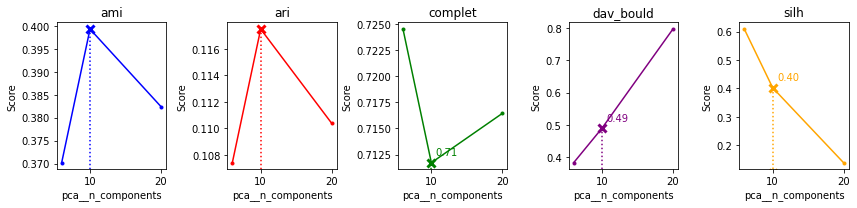

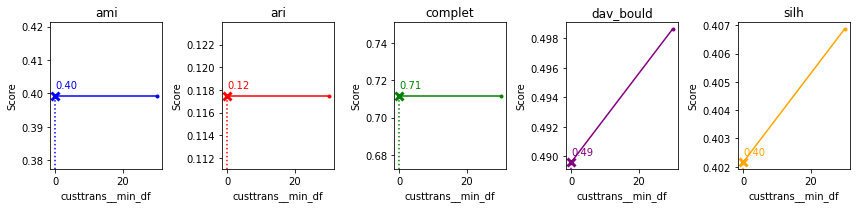

In [47]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc_pname, param='pca__n_components', title=None,
                      scores=['ari', 'ami', 'complet', 'dav_bould', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

plot_gsc_multi_scores(gsc=gsc_pname, param='custtrans__min_df', title=None,
                      scores=['ari', 'ami', 'complet', 'dav_bould', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

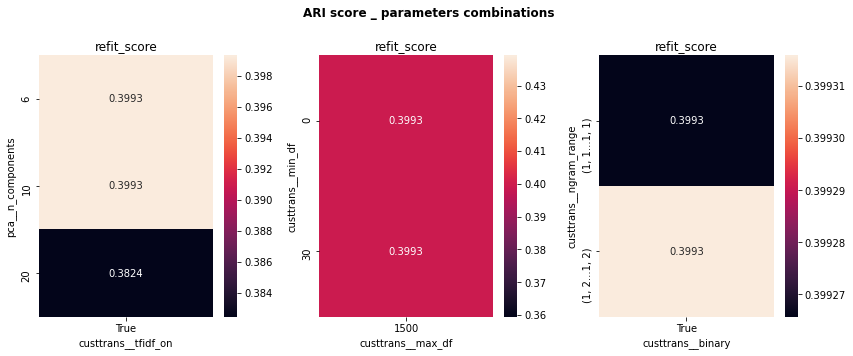

In [48]:
# Effect of 2 parameters on clustering scores

params1 = ['pca__n_components', 'custtrans__tfidf_on']
params2 = ['custtrans__min_df', 'custtrans__max_df']
params3 = ['custtrans__ngram_range', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc_pname, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc_pname, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc_pname, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

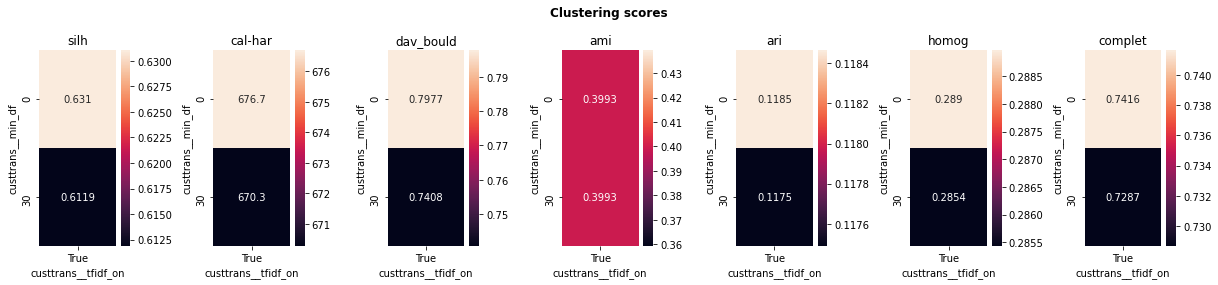

In [49]:
# Choosen list of scores through 2 chosen parameters

fig = plt.figure(figsize=(17,4))
params = ['custtrans__min_df', 'custtrans__tfidf_on']

scores =  list(gsc.get_params()['scoring']) # ['ami', 'ari', 'complet']
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc_pname, params=params,
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

#### preprocessing and the method chosen for topics modeling

Optimisation using a custom GridSearch adapted for clustering.

Using either 'descriptions' or 'product_name'

The pipeline to be optimized has 2 steps:
- Custom NLP transformer (BOW or TFIDF matrix)
- Clustering using topics modeling (7 topics)

In [50]:
import copy
from sklearn.pipeline import Pipeline
from sklearn.metrics import silhouette_score, calinski_harabasz_score,\
 davies_bouldin_score, adjusted_mutual_info_score, adjusted_rand_score,\
 homogeneity_score, completeness_score
from sklearn.decomposition import PCA
from nltk.stem.snowball import EnglishStemmer
import spacy

# Define the stemmer or the lemmatizer
stemmer = EnglishStemmer()
lemmatizer = spacy.load('en', disable=['parser', 'ner'])


# Define the pipeline to be executed and optimized by the GridSearch
pipe = Pipeline([('custtrans', CustNLPTransformer()), # Custom NLP preprocessor
                 ('clusterer', TopicsModeler(random_state=14))]) # KMeans clusterer

# Define the list of params to be tested in the GridSearchClust
param_grid = {'custtrans__stopwords': [sw], # [sw, None],
              'custtrans__stemmer': [None],#[stemmer, None],
              'custtrans__lemmatizer': [lemmatizer], #, None],
              'custtrans__min_df': (np.linspace(0,30,2)).astype('int'),
              'custtrans__max_df': [None],
              'custtrans__max_features': [5000],
              'custtrans__ngram_range': [(1,1), (1,2)], #, (2,2), (2,3), (3,3), (1,2,3)],
              'custtrans__binary': [True], #, False],
              'custtrans__tfidf_on': [True], # , False],
              'clusterer__n_model': ['lsa', 'nmf', 'lda'],
              'clusterer__n_components': [7]
              }

# Instanciate of the GridSearch object
gsc = GridSearchClust(estimator=pipe,
                      param_grid_estim=param_grid,
                      scoring=['silh', 'cal-har', 'dav_bould',
                               'ami', 'ari', 'homog', 'complet'],
                      scoring_true_lab=df_desc_cat['category'],
                      refit='ami',
                      greater_is_better=True) # for the refit_score

In [51]:
##### Perform the grid search on the whole descriptions
gsc_desc = copy.deepcopy(gsc)
gsc_desc.fit(df_desc_cat['description'], verbose=False);

##### Perform the grid search on the product names
gsc_pname = copy.deepcopy(gsc)
gsc_pname.fit(df_desc_cat['product_name'], verbose=False);

Code to pickle the results of a grisdearch in a .pkl file

In [52]:
# ### Pickling the results
# import dill as pickle
# with open('gsc_prep_pca_tm_WD.pkl', 'wb') as file:
#     pickle.dump(gsc_desc, file)
# with open('gsc_prep_pca_tm_PN.pkl', 'wb') as file:
#     pickle.dump(gsc_pname, file)

Code to load pickled results

In [53]:
# ### Loading the results
# import dill as pickle
# with open('gsc_prep_pca_tm_WD.pkl', 'rb') as file:
#     gsc_desc = pickle.load(file)
# with open('gsc_prep_pca_tm_PN.pkl', 'rb') as file:
#     gsc_pname = pickle.load(file)

In [54]:
# Display results (whole descriptions)
print("-----Whole descriptions")
print("Best hyperparameters:", gsc_desc.best_params_)
print("Best refit score:", gsc_desc.best_score_)
gsc_desc_res = gsc_desc.results_
scores_desc_df = pd.DataFrame(gsc_desc_res['scores'],
                              index = pd.DataFrame(gsc_desc_res['params']).iloc[:,0])

# Display results (products name)
print("-----Product name")
print("Best hyperparameters:", gsc_pname.best_params_)
print("Best refit score:", gsc_pname.best_score_)
gsc_pname_res = gsc_pname.results_
scores_pname_df = pd.DataFrame(gsc_pname_res['scores'],
                         index = pd.DataFrame(gsc_pname_res['params']).iloc[:,0])

-----Whole descriptions
Best hyperparameters: {'clusterer__n_components': 7, 'clusterer__n_model': 'nmf', 'custtrans__binary': True, 'custtrans__lemmatizer': <spacy.lang.en.English object at 0x7f8ee9ec7a90>, 'custtrans__max_df': None, 'custtrans__max_features': 5000, 'custtrans__min_df': 0, 'custtrans__ngram_range': (1, 1), 'custtrans__stemmer': None, 'custtrans__stopwords': ['the', 'those', 'didn', 'but', 'needn', 'because', 'you', 'been', 'being', "couldn't", "shouldn't", 'v', 'only', 'under', "needn't", 'who', 'most', "shan't", 'should', 'not', 'did', 'doesn', 'when', 'b', 'ourselves', "aren't", 'a', 'h', 'shouldn', 'f', 'some', 'further', 'same', 'her', "weren't", 'theirs', 'more', 'p', 'until', 'then', 'll', 'k', 'any', 'i', 'during', 'y', 'if', 'them', 'all', 'your', 'now', 'q', 'which', 'just', 'he', 'mightn', 'as', 'than', "that'll", 'we', 'up', 'weren', "mightn't", 'it', 'an', 'no', "you're", 'very', "won't", 'yourselves', 'on', 'hasn', 'these', 'my', "hadn't", 'shan', 'so', '

In [55]:
scores_pname_df

,silh,cal-har,dav_bould,ami,ari,homog,complet
clusterer__n_components,,,,,,,
7,0.04,15.02,5.24,0.46,0.34,0.43,0.51
7,0.04,15.02,5.24,0.46,0.34,0.43,0.51
7,0.04,15.02,5.24,0.46,0.34,0.43,0.51
7,0.04,15.02,5.24,0.46,0.34,0.43,0.51
7,0.05,16.94,5.29,0.48,0.40,0.47,0.49
7,0.05,16.94,5.29,0.48,0.40,0.47,0.49
7,0.05,16.94,5.29,0.48,0.40,0.47,0.49
7,0.05,16.94,5.29,0.48,0.40,0.47,0.49
7,0.01,7.80,7.65,0.20,0.17,0.21,0.21


Plotting the results of the clustering optimization

In [56]:
# Compute the dataframe showing the results depending on one parameter
#(other parameters set tot best_params_)

best_params, df_sel_scores, df_gsclust_filt, df_res = \
            filters_gsclust_results(gsc_pname, 'clusterer__n_model',
                                    return_df_res=True)
df_sel_scores

,silh,cal-har,dav_bould,ami,ari,homog,complet
clusterer__n_model,,,,,,,
lsa,0.04,15.02,5.24,0.46,0.34,0.43,0.51
nmf,0.05,16.94,5.29,0.48,0.40,0.47,0.49
lda,0.01,7.80,7.65,0.20,0.17,0.21,0.21


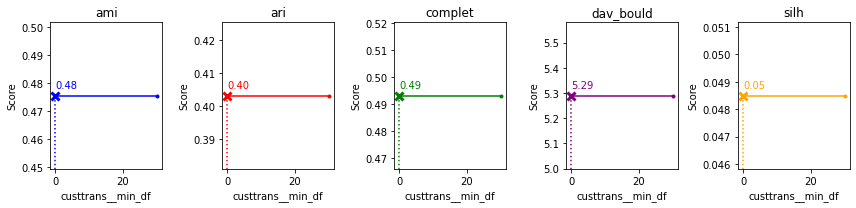

In [57]:
# Plotting the graphs of the clustering scores with best refit score (line)

plot_gsc_multi_scores(gsc=gsc_pname, param='custtrans__min_df', title=None,
                      scores=['ari', 'ami', 'complet', 'dav_bould', 'silh'],
                      x_log=False, loc='best', figsize=(12, 3))

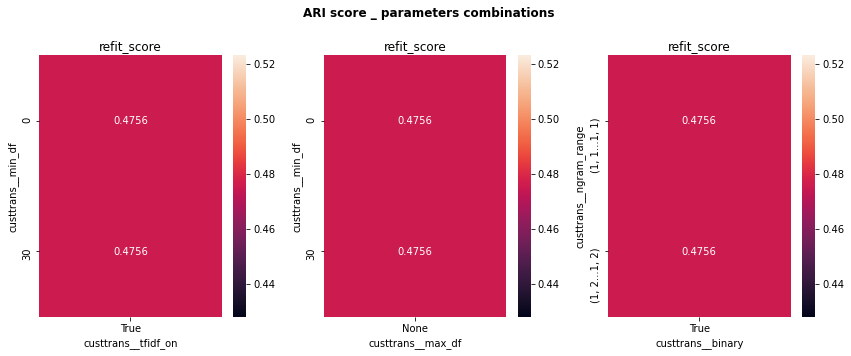

In [58]:
# Effect of 2 parameters on clustering scores

params1 = ['custtrans__min_df', 'custtrans__tfidf_on']
params2 = ['custtrans__min_df', 'custtrans__max_df']
params3 = ['custtrans__ngram_range', 'custtrans__binary']

fig = plt.figure(figsize=(12,5))

ax1 = fig.add_subplot(1,3,1)
plot_2D_gsclust_param_opt(gsc_pname, params=params1, shorten_label=5, ax=ax1)

ax2 = fig.add_subplot(1,3,2)
plot_2D_gsclust_param_opt(gsc_pname, params=params2, shorten_label=5, ax=ax2)

ax3 = fig.add_subplot(1,3,3)
plot_2D_gsclust_param_opt(gsc_pname, params=params3, shorten_label=5, ax=ax3)

plt.gcf().suptitle('ARI score _ parameters combinations', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])

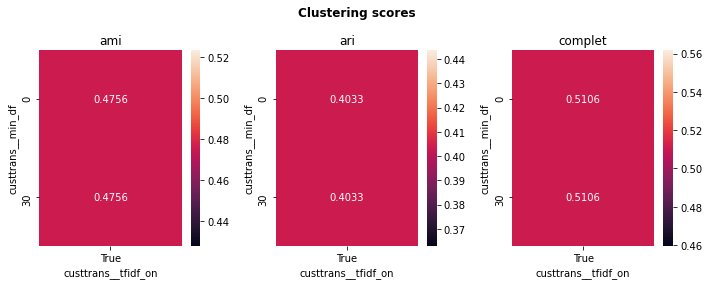

In [59]:
# All the scores through 2 chosen parameters

fig = plt.figure(figsize=(10,4))
params = ['custtrans__min_df', 'custtrans__tfidf_on']

scores = ['ami', 'ari', 'complet'] # list(gsc.get_params()['scoring'])
### Looping on all the scores
for i, score in enumerate(scores, 1):
    ax = fig.add_subplot(1,len(scores),i)
    plot_2D_gsclust_param_opt(gsc_pname, params=params,
                              score=score, title=None, ax=ax)
    
plt.gcf().suptitle('Clustering scores', fontweight='bold')
plt.tight_layout(rect=[0,0,1,0.92])